Before we start doing anything, I think it's important to understand for NLP, this is the intuitive process on what we are trying to do when we are processing our data in the IMDB dataset:
1. Tokenization: break sentence into individual words
    - Before: `"PyTorch seems really easy to use!"`
    - After: `["PyTorch", "seems", "really", "easy", "to", "use", "!"]`
2. Building vocabulary: build an index of words associated with unique numbers
    - Before: `["PyTorch", "seems", "really", "easy", "to", "use", "!"]`
    - After: `{"Pytorch: 0, "seems": 1, "really": 2, ...}`
3. Convert to numerals: map words to unique numbers (indices)
    - Before: `{"Pytorch: 0, "seems": 1, "really": 2, ...}`
    - After: `[0, 1, 2, ...]`
4. Embedding look-up: map sentences (indices now) to fixed matrices
    - ```[[0.1, 0.4, 0.3],
       [0.8, 0.1, 0.5],
       ...]```

In [1]:
# Critical plotting imports
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch imports
from torchtext import data, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F

# Checking for iterable objects
import collections
import random

In [2]:
# Set seed
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1337)

In [3]:
# Set plotting style
plt.style.use(('dark_background', 'bmh'))
plt.rc('axes', facecolor='none')
plt.rc('figure', figsize=(16, 4))

In [4]:
# Create instances of fields
# The important field here is fix_length: all examples using this field will be padded to, or None for flexible sequence lengths
# We are fixing this because we will be using a FNN not an LSTM/RNN/GRU where we can go through uneven sequence lengths
max_len = 80
text = data.Field(sequential=True, fix_length=max_len, batch_first=True, lower=True, dtype=torch.long)
label = data.LabelField(sequential=False, dtype=torch.float)

In [5]:
# Calling splits() class method of datasets.IMDB to return a torchtext.data.Dataset object
ds_train, ds_test = datasets.IMDB.splits(text, label)

In [6]:
# Training and test set each 25k samples
# 2 fields due to the way we split above
print('train : ', len(ds_train))
print('test : ', len(ds_test))
print('train.fields :', ds_train.fields)

train :  25000
test :  25000
train.fields : {'label': <torchtext.data.field.LabelField object at 0x7fb86f78d630>, 'text': <torchtext.data.field.Field object at 0x7fb86f78d668>}


In [7]:
# Get validation set
seed_num = 1337
ds_train, ds_valid = ds_train.split(random_state=random.seed(seed_num))

In [8]:
# Now we've training, validation and test set
print('train : ', len(ds_train))
print('valid : ', len(ds_valid))
print('valid : ', len(ds_test))

train :  17500
valid :  7500
valid :  25000


In [9]:
# Build vocabulary
# num_words = 25000
num_words = 1000
text.build_vocab(ds_train, max_size=num_words)
label.build_vocab(ds_train)

In [10]:
# Print vocab size
print('Vocabulary size: {}'.format(len(text.vocab)))
print('Label size: {}'.format(len(label.vocab)))

Vocabulary size: 1002
Label size: 2


In [11]:
# Print most common vocabulary text
most_common_samples = 10
print(text.vocab.freqs.most_common(most_common_samples))

[('the', 225938), ('a', 112571), ('and', 111513), ('of', 101389), ('to', 94175), ('is', 72550), ('in', 63886), ('i', 49428), ('this', 49096), ('that', 46809)]


In [12]:
# Print most common labels
print(label.vocab.freqs.most_common())

[('neg', 8835), ('pos', 8665)]


In [13]:
# Sample 0 label
ds_train[0].label

'neg'

In [14]:
# Sample 0 text: broken down into individual portions
ds_train[0].text

['first',
 'of',
 'all',
 'i',
 'just',
 'want',
 'to',
 'say',
 'that',
 'i',
 'love',
 'this',
 'show!!!',
 'but',
 'this',
 'episode...this',
 'episode',
 'makes',
 'a',
 'mockery',
 'of',
 'the',
 'entire',
 'show.<br',
 '/><br',
 '/>i',
 "don't",
 'know',
 'what',
 'they',
 'tried',
 'to',
 'achieve',
 'with',
 'this',
 'episode',
 'but',
 'they',
 'successfully',
 'created',
 'the',
 'worst',
 'episode',
 'in',
 'the',
 'entire',
 'series.<br',
 '/><br',
 '/>there',
 'is',
 'no',
 'story',
 'line,',
 'everything',
 'is',
 'chaotic',
 'and',
 'the',
 'jokes.....are',
 'crap.<br',
 '/><br',
 '/>the',
 'way',
 'they',
 'tried',
 'to',
 'answer',
 'some',
 'of',
 'the',
 'remaining',
 'questions',
 'in',
 'the',
 'game.....',
 'for',
 'example',
 '"how',
 'do',
 'the',
 'furlings',
 'look',
 'like"',
 'by',
 'creating',
 'that',
 'stupid',
 '"previously',
 'on..."......is',
 'simply',
 'embarrassing.<br',
 '/><br',
 '/>its',
 'clear',
 'that',
 'the',
 'writers',
 'are',
 'running',


In [15]:
# Sample 0 text: human readeable sample
def show_text(sample):
    print(' '.join(word for word in sample))
    
show_text(ds_train[0].text)

first of all i just want to say that i love this show!!! but this episode...this episode makes a mockery of the entire show.<br /><br />i don't know what they tried to achieve with this episode but they successfully created the worst episode in the entire series.<br /><br />there is no story line, everything is chaotic and the jokes.....are crap.<br /><br />the way they tried to answer some of the remaining questions in the game..... for example "how do the furlings look like" by creating that stupid "previously on..."......is simply embarrassing.<br /><br />its clear that the writers are running out of ideas and that is really too bad.


In [16]:
# Create and iterable object for our training, validation and testing datasets
# Batches examples of similar lengths together that minimizes amount of padding needed
batch_size = 64  # Change batch size from 1 to bigger number once explanation is done
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=batch_size, sort_key=lambda x: len(x.text), repeat=False
)

In [17]:
# Check if iterator above is an iterable which should show True
isinstance(train_loader, collections.Iterable)

True

In [18]:
# What's inside this iteratable object? Our text and label although now everything is in machine format (not "words") but in numbers!
# The text we saw above becomes a matrix of size 1 x 80 represented by the fixed length we defined before that
list(train_loader)[0]


[torchtext.data.batch.Batch of size 64]
	[.label]:[torch.FloatTensor of size 64]
	[.text]:[torch.LongTensor of size 64x80]

In [19]:
# Alternative to above, this is much faster but the above code is easy to understand and implement
next(train_loader.__iter__())


[torchtext.data.batch.Batch of size 64]
	[.label]:[torch.FloatTensor of size 64]
	[.text]:[torch.LongTensor of size 64x80]

In [20]:
test_batch = next(train_loader.__iter__())

In [21]:
# What methods can we call on this batch object? Text and label
test_batch.fields

dict_keys(['label', 'text'])

In [22]:
# Let's break this down to check what's in a batch
test_batch.text

tensor([[   9,   61,  222,  ...,   37,    2,    0],
        [   0,  173,    6,  ...,    1,    1,    1],
        [ 944,    0,  397,  ...,   44,    0,    0],
        ...,
        [   9,   54,  499,  ...,    0,   11,  112],
        [   9,  222,    3,  ...,  161,   14,    8],
        [  49,    9,   82,  ...,    3,   56,    0]])

In [23]:
# 1 comment per batch, each comment is limited to a size of 80 as we've defined
test_batch.text.size()

torch.Size([64, 80])

In [24]:
test_batch.label

tensor([ 1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
         0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  1.])

In [25]:
# Extremely weird problem in torchtext where BucketIterator returns a Batch object versus just a simple tuple of tensors containing our text index and labels
# So let's fix this with a new class FixBatchGenerator

class FixBatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)
            
train_loader, valid_loader, test_loader = FixBatchGenerator(train_loader, 'text', 'label'), FixBatchGenerator(valid_loader, 'text', 'label'), FixBatchGenerator(test_loader, 'text', 'label')

In [26]:
# Text index
print(next(train_loader.__iter__())[0])

# Text label
print(next(train_loader.__iter__())[1])

tensor([[  441,   103,   581,  ...,     1,     1,     1],
        [    0,   224,   399,  ...,   229,     3,     0],
        [   49,    25,   208,  ...,   599,     0,     0],
        ...,
        [    9,    14,    23,  ...,     0,    14,    50],
        [   10,     7,     3,  ...,     0,    38,   284],
        [  194,    71,     3,  ...,   186,     4,   312]])
tensor([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
         1.,  0.,  1.,  0.])


In [27]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Linear function
        self.fc1 = nn.Linear(embedding_dim*embedding_dim, hidden_dim) 

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        embedded = embedded.view(-1, embedding_dim*embedding_dim)
        # Linear function  # LINEAR
        out = self.fc1(embedded)

        # Non-linearity  # NON-LINEAR
        out = F.relu(out)
        out = F.dropout(out, 0.8)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        out = F.sigmoid(out)
    
        return out

In [28]:
input_dim = num_words + 2
embedding_dim = max_len
hidden_dim = 32
output_dim = 1

# Instantiate model class and assign to object
model = FeedforwardNeuralNetModel(input_dim, embedding_dim, hidden_dim, output_dim)

# Push model to CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [29]:
# Number of groups of parameters
print('Number of groups of parameters {}'.format(len(list(model.parameters()))))
print('-'*50)
# Print parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
print('-'*50)

Number of groups of parameters 5
--------------------------------------------------
torch.Size([1002, 80])
torch.Size([32, 6400])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
--------------------------------------------------


In [30]:
iter = 0
num_epochs = 25
history_train_acc, history_val_acc, history_train_loss, history_val_loss = [], [], [], []
for epoch in range(num_epochs):
#     print('-'*50)
    for i, (samples, labels) in enumerate(train_loader):
        # Training mode
        model.train()
        
        # Load samples
        samples = samples.view(-1, max_len).to(device)
        labels = labels.view(-1, 1).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(samples)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Get training statistics
            train_loss = loss.data.item()
            
            # Testing mode
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for samples, labels in valid_loader:
                # Load samples
                samples = samples.view(-1, max_len).to(device)
                labels = labels.view(-1).to(device)

                # Forward pass only to get logits/output
                outputs = model(samples)
                
                # Val loss
                val_loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))
                
                # We use a threshold to define 
                predicted = outputs.ge(0.5).view(-1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum()
            
            accuracy = 100. * correct.item() / total
            # Print Loss
            print('Iter: {} | Train Loss: {} | Val Loss: {} | Val Accuracy: {}'.format(iter, train_loss, val_loss.item(), round(accuracy, 2)))
            
            # Append to history
            history_val_loss.append(val_loss.data.item())
            history_val_acc.append(round(accuracy, 2))
            history_train_loss.append(train_loss)

Iter: 100 | Train Loss: 0.6980435848236084 | Val Loss: 0.6868502497673035 | Val Accuracy: 51.95
Iter: 200 | Train Loss: 0.6644342541694641 | Val Loss: 0.6923518180847168 | Val Accuracy: 53.36
Iter: 300 | Train Loss: 0.6613801717758179 | Val Loss: 0.760021448135376 | Val Accuracy: 54.97
Iter: 400 | Train Loss: 0.673904299736023 | Val Loss: 0.7628712058067322 | Val Accuracy: 55.55
Iter: 500 | Train Loss: 0.6563446521759033 | Val Loss: 0.7760634422302246 | Val Accuracy: 56.53
Iter: 600 | Train Loss: 0.5828384160995483 | Val Loss: 0.7273943424224854 | Val Accuracy: 57.37
Iter: 700 | Train Loss: 0.5236313939094543 | Val Loss: 0.7867918014526367 | Val Accuracy: 57.73
Iter: 800 | Train Loss: 0.5789859294891357 | Val Loss: 0.762665331363678 | Val Accuracy: 57.89
Iter: 900 | Train Loss: 0.5666465163230896 | Val Loss: 0.7606501579284668 | Val Accuracy: 58.16
Iter: 1000 | Train Loss: 0.5156959891319275 | Val Loss: 0.7643177509307861 | Val Accuracy: 58.05
Iter: 1100 | Train Loss: 0.469226121902465

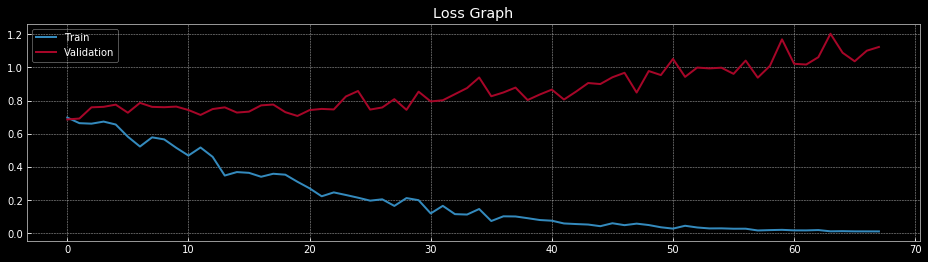

In [31]:
plt.plot(history_train_loss, label='Train')
plt.plot(history_val_loss, label='Validation')
plt.title('Loss Graph')
plt.legend()
plt.show()

Text(0.5,1,'Validation Accuracy')

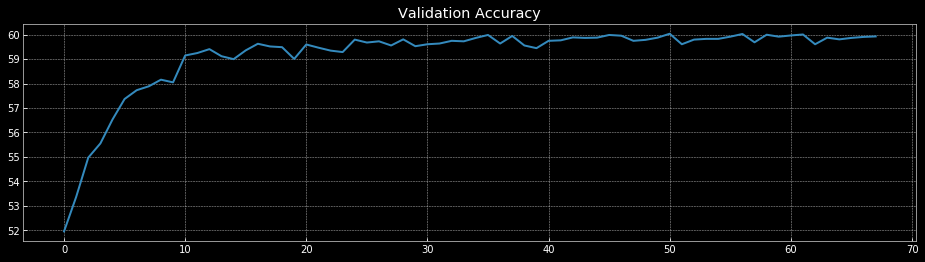

In [32]:
plt.plot(history_val_acc)
plt.title('Validation Accuracy')